<a href="https://colab.research.google.com/github/r3m3dial-g3nius/dog-breed-classification/blob/main/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Class Dog Breed Classification
This notebook builds an end=to=end multiclass image classifier using TensorFlow 2.0 and TensorFlow Hub

## 1. Problem

Identify the breed of a dog in an image

## 2. Data

The data used is from Kaggle's dog breed identification competition.
https://www.haggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Info about the data:

* 20,000+ images (unstructured data)
* Multiclass identification (120 classes)
* 10,000+ images in the training set (labelled)
* 10,000+ images in the test set (not labeled)


In [60]:
# Unzip the uploaded data into Google Drive

#!unzip "/content/drive/MyDrive/Colab Notebooks/dog-breed-classifier/dog-breed-identification"

# Prep workspace

In [59]:
# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

# Check for GPU availability
print("GPU", "available :)" if tf.config.list_physical_devices("GPU") else "not available! :(")

TF version:  2.14.0
Hub version:  0.15.0
GPU available :)


In [61]:
import pandas as pd

# Check the labels on the data
labels_csv = pd.read_csv("drive/My Drive/Colab Notebooks/dog-breed-classifier/labels.csv")

In [62]:
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: >

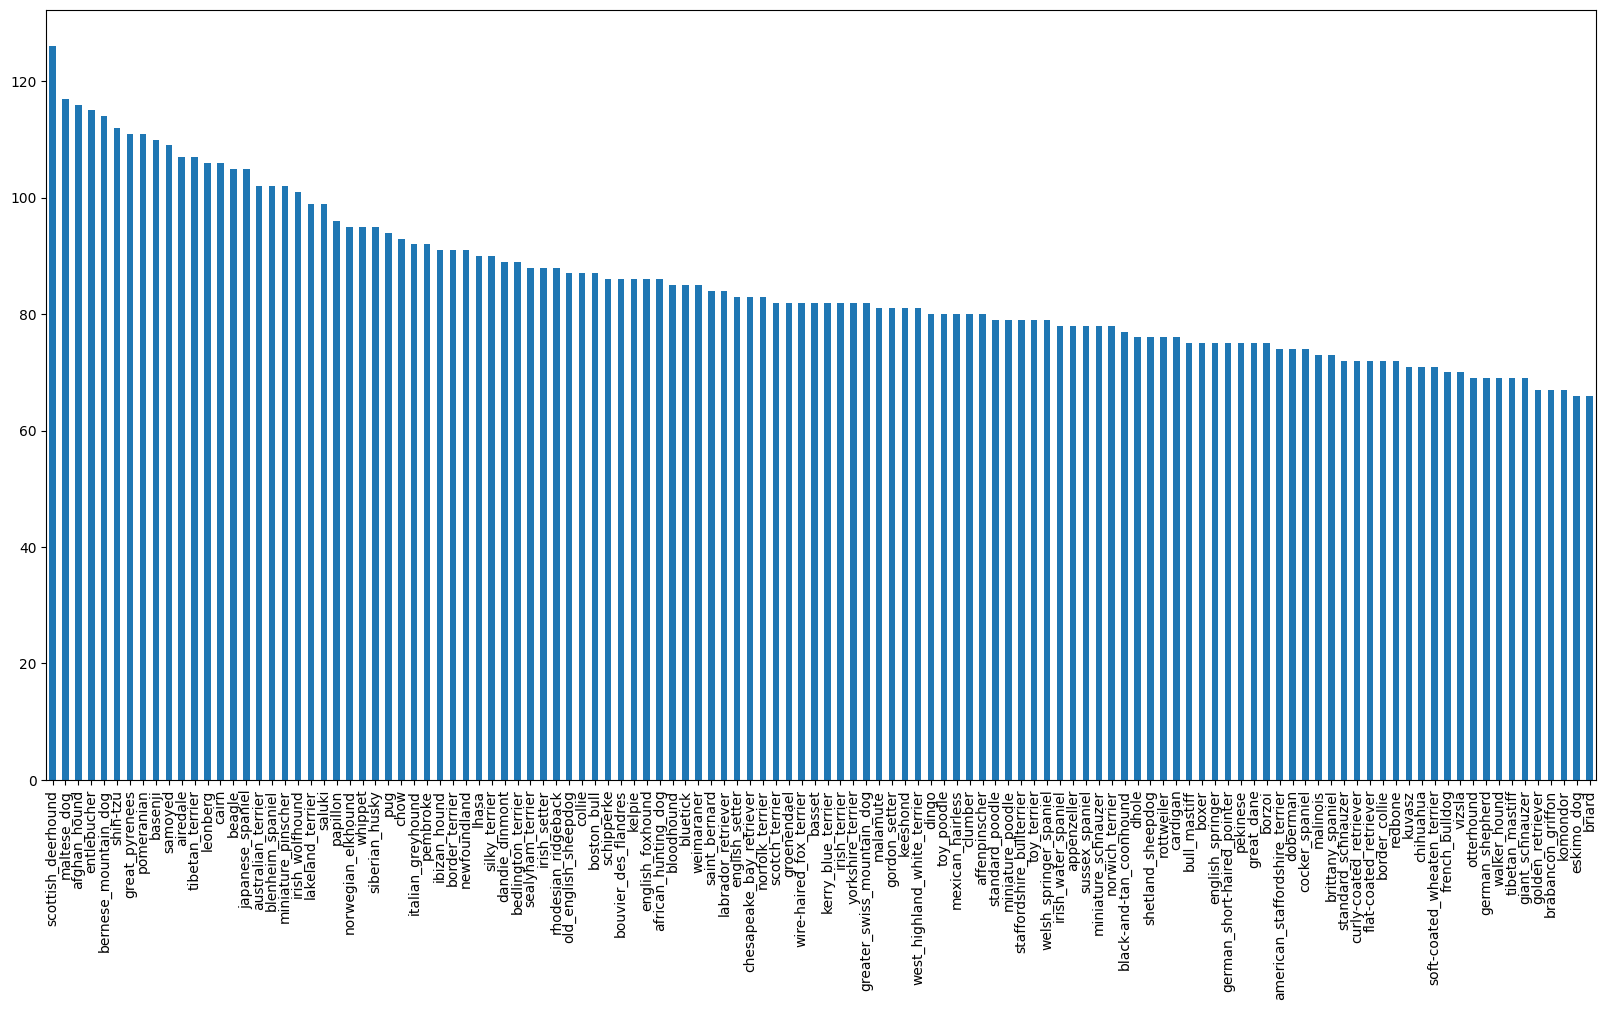

In [63]:
# How many images exist for each breed?
labels_csv.breed.value_counts().plot.bar(figsize=(20,10))

In [64]:
# Median number of images per class
labels_csv.breed.value_counts().median()

82.0

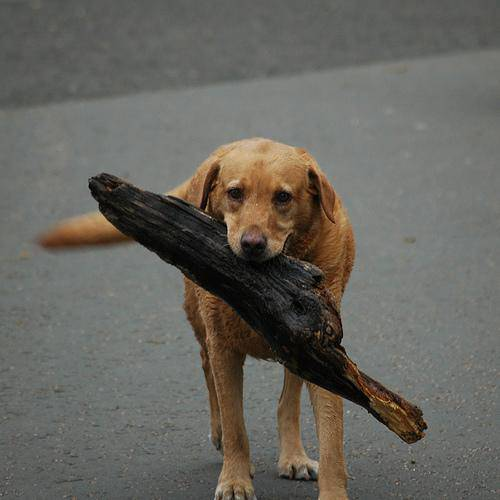

In [65]:
# View an image
from IPython.display import Image

Image("drive/My Drive/Colab Notebooks/dog-breed-classifier/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Get a list of all image file pathnames

In [66]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [67]:
# Create pathnames from image IDs
filepaths = ["drive/My Drive/Colab Notebooks/dog-breed-classifier/train/" + fname + ".jpg" for fname in labels_csv.id]

# Check first 10
filepaths[:10]

['drive/My Drive/Colab Notebooks/dog-breed-classifier/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Colab Notebooks/dog-breed-classifier/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [68]:
# Verify length of filepaths to original data source
import os

if len(os.listdir("drive/My Drive/Colab Notebooks/dog-breed-classifier/train/")) == len(filepaths):
  print("Number of filepaths match number of files :)")
else:
  print("CAUTION - Number of filepaths do not match number of files! Check target directory.")

Number of filepaths match number of files :)


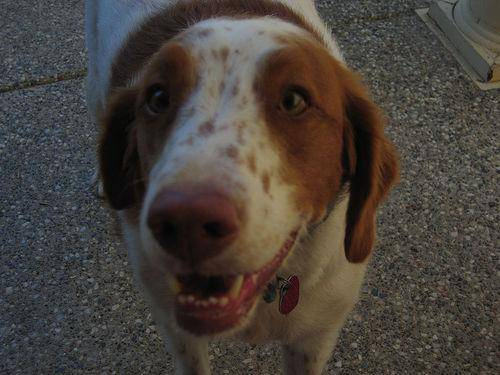

In [69]:
# Check filepaths shortcut
Image(filepaths[77])

In [70]:
labels_csv.breed[77]

'brittany_spaniel'

## Prep the labels

In [71]:
import numpy as np

labels = labels_csv.breed
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [72]:
len(labels)

10222

In [73]:
# Verify length of labels to length of filepaths

if len(labels) == len(filepaths):
  print("Number of labels match number of filepaths :)")
else:
  print("CAUTION - Number of labels do not match number of filepaths! Check data directories.")

Number of labels match number of filepaths :)


In [74]:
# Identify unique label values
unique_breeds = np.unique(labels)
print(unique_breeds[:20])
print(len(unique_breeds))

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull']
120


In [75]:
# Convert each label to boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [76]:
len(boolean_labels)

10222

## Create a validation set

In [77]:
# setup X & y
X = filenames
y = boolean_labels

In [78]:
len(X)

10222

In [79]:
# Experiment w subset of 1k images - increase as needed

# Create a slider
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [80]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

# use NUM_IMAGES slider to determine subset size
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

## Preprocess images into Tensors

Create preprocessing function to:
1. Take image filepath as input
2. Use TensorFlow to read the file and save it to a variable, 'image'
3. Convert 'image.jpg' into Tensors
4. Normalize image (convert color channel values from 0-255 to 0-1)
5. Resize 'image' to be a shape of (224, 224)
6. Return modified 'image'

In [84]:
# Define image size
IMG_SIZE = 224

# Create preprocess_image function
def preprocess_image(image_path, img_size=IMG_SIZE):
  """
  Takes image and converts to Tensor
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Convert image.jpg into numerical Tensor w 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalize image - Convert color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image
  image= tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turn data into batches

Split data into batches of 32 tuples in this format: (image, label)

In [85]:
# Create a function that returns a tuple
def get_image_label(image_path, label):
  """
  Takes an image filepath name and associated label,
  processes the image,
  returns a tuple (image, label).
  """
  image = preprocess_image(image_path)
  return image, label

In [87]:
# Demo above function
(preprocess_image(X[42], tf.constant(y[42])))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

In [93]:
# Create a function to convert all of the data (X & y) into batches

# Define batch size
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image 'X' and label 'y' pairs.
  Shuffles the data if its training data, but not validation data.
  Also accepts test data as input (no labels).
  """
  # If data is test dataset, there are no labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))   # only filepaths, no labels
    data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch

  # If data is valid dataset, data is NOT shuffled
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # If data is training dataset, shuffle the data
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffle the pathnames and labels before mapping
    data = data.shuffle(buffer_size=len(X))

    # Create image label tuples () **This also turns image path into a preprocessed image**
    data = data.map(get_image_label)

    # Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch


In [94]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [95]:
# Review elements of data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [104]:
import matplotlib.pyplot as plt

# Create a function for viewing an image in a databatch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a databatch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop thru 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 cols)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # grid lines off
    plt.axis("off")

In [105]:
len(train_images), len(train_labels)

(32, 32)

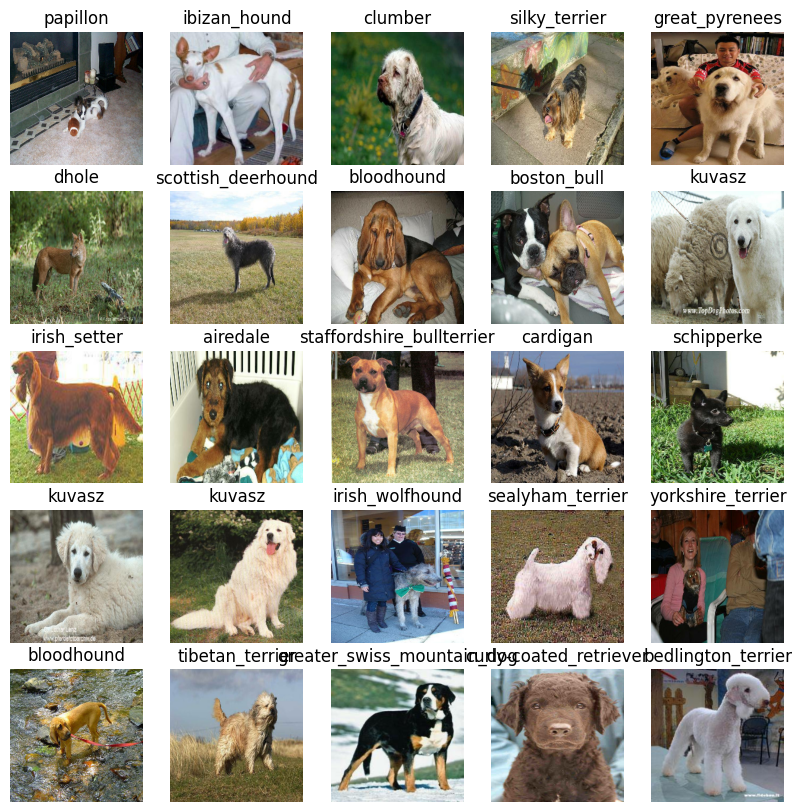

In [110]:
# Visualize the training data using custom function from above:
train_images, train_labels = next(train_data.as_numpy_iterator())

show_25_images(train_images, train_labels)

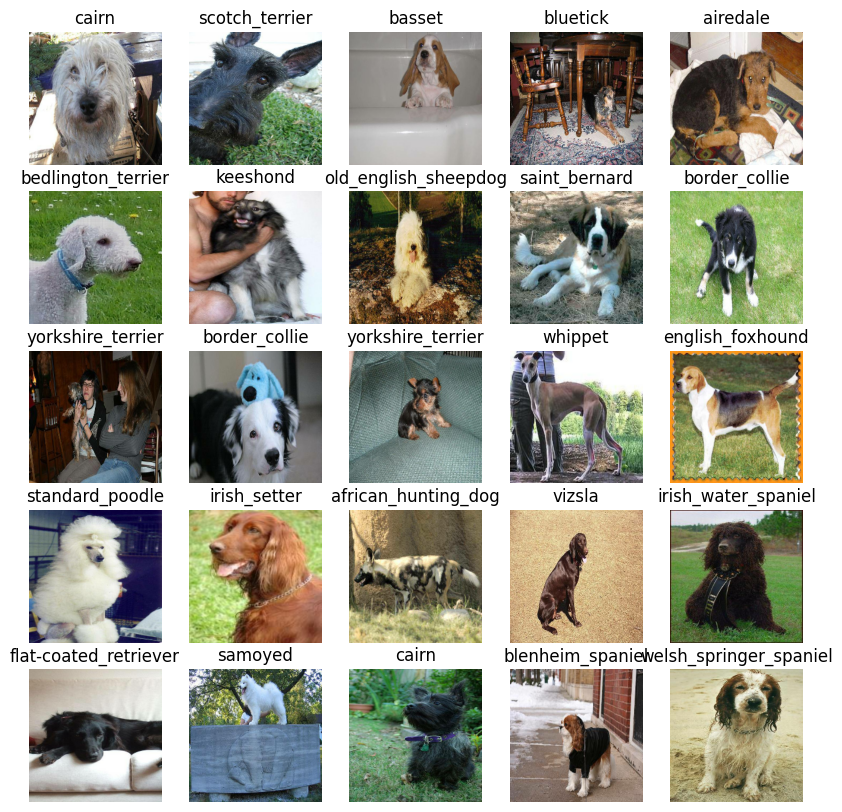

In [112]:
# Visualize the validation set

val_images, val_labels = next(val_data.as_numpy_iterator())

show_25_images(val_images, val_labels)

# Build a model
* Define input shape (in the form of Tensors)
* Define the output shape (in the form of Tensors)
* URL of model from TensorFlow Hub

In [121]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output shape
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

## Create a function to:

* Take input shape, output shape, and model chosen as parameters
* Define layers in Keras model in sequential fashion
* Compile the model
* Build the model
* Return the model

In [122]:
# Create function that builds Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", MODEL_URL)

  # Setup model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
      activation="softmax")   # Layer 2 (Outputlayer)
      ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [123]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

A callback is a helper function that a model can use during training to save progress, check progress, or stop training early if model stops improving.

Two callbacks are created here. One for TensorBoard which helps track the model's progress. A second for early stopping which prevents the model from training for too long.

### TensorBoard callback
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's 'fit()' function.
3. Visualize the model's training logs with the %tensorboard magic function.

In [127]:
# Load Tensorboard notebook extension
!pip install tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [128]:
import datetime

# Create a function to callback a tensorboard callback
def create_tensorboard_callback():
  # create a log directory for storing Tensorboard logs
  logdir = os.path.join("drive/MyDrive/Colab Notebooks/dog-breed-classifier/logs",  # make the logs get tracked when running an experiment
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)